In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import datetime
import arviz
import seaborn as sns
import scipy
import sklearn.metrics
sns.set()

In [2]:
from nowcasting_functions import *

### Compile all models

In [3]:
m1 = pystan.StanModel(file='stan_models/4SE_r_gamma_60_2.stan')
m2 = pystan.StanModel(file='stan_models/4SE_r_gamma_500_2.stan')
m3 = pystan.StanModel(file='stan_models/4SE_r_gamma_1000_2.stan')
m4 = pystan.StanModel(file='stan_models/4SE_r_normal_0_1.stan')
m5 = pystan.StanModel(file='stan_models/4SE_r_normal_100_10.stan')


print('All models compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_33eb063e88675cc8826789b9cba4e88d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fc993fd7bf0aedb8928d1ca1f5149e1 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2174b51996b7e387c269721d3bed32da NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1c332fb0f64d7a26b6f8b1804c29875 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d2a817bc486a9e82445c5ff7aaeb08c NOW.


All models compiled


### Prepare the data

In [4]:
data = pd.read_csv('../data/df_SIVEP_nowcast_allStates_08-02-2021.csv')
def get_state_data(df, state):
    df_state = df.copy()
    if state == 'Brazil':
        df_state.drop(columns=['State'], inplace=True)
        columns = list(df_state.columns)
        columns.remove('Deaths')
        df_state = df_state.groupby(columns, as_index=False)['Deaths'].sum()
        return df_state
    return df_state[df_state['State'] == state]

data = get_state_data(data, 'Brazil')
max_D = 10
data_new = data.copy()
data_new['Release_index'] = data_new.Release.astype('category').cat.codes
data_new = data_new[data_new['Date'] >= '2020-06-30'] # cut off early days as they are less relevant
data_new = data_new[data_new['Release'] >= '2020-06-30'] # cut off early days as they are less relevant
data_new = data_new[data_new['Release'] <= '2021-01-11'] 
data_new

,Date,Release,Date_index,Release_index,Deaths
5760,2020-06-30,2020-07-07,181,0,722
5761,2020-06-30,2020-07-14,181,1,933
5762,2020-06-30,2020-07-21,181,2,1025
5763,2020-06-30,2020-07-29,181,3,1091
5764,2020-06-30,2020-08-03,181,4,1116
...,...,...,...,...,...
9360,2021-01-07,2021-01-11,372,27,532
9365,2021-01-08,2021-01-11,373,27,400
9370,2021-01-09,2021-01-11,374,27,309
9375,2021-01-10,2021-01-11,375,27,217


In [5]:
data_new.Release.unique()

array(['2020-07-07', '2020-07-14', '2020-07-21', '2020-07-29',
       '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
       '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
       '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
       '2020-10-26', '2020-11-02', '2020-11-10', '2020-11-16',
       '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
       '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11'],
      dtype=object)

In [6]:
def fit_sensitivity_model(model):
    fit, results = fit_model(data_new, precompiled=False, modelname=model, date_nowcast=None,
              maxD=10, iters=1000, warmup=400, chains=4, adapt_delta=0.95,
              max_treedepth=12, seed=9876,
              pickle_run=False, save=False, savepath='')
    return fit, results


In [7]:
all_models = [m1,m2,m3,m4,m5]
models_names = ['gamma_60_2', 'gamma_500_2', 'gamma_1000_2', 
                'normal_0_1', 'normal_100_10']

fit1, results_1 = fit_sensitivity_model(all_models[0])
print('Fitting done for', models_names[0])
fit2, results_2 = fit_sensitivity_model(all_models[1])
print('Fitting done for', models_names[1])
fit3, results_3 = fit_sensitivity_model(all_models[2])
print('Fitting done for', models_names[2])
fit4, results_4 = fit_sensitivity_model(all_models[3])
print('Fitting done for', models_names[3])

print('Fitting done for all')
    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Fitting done for gamma_60_2


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Fitting done for gamma_500_2


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Fitting done for gamma_1000_2


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Fitting done for normal_0_1
Fitting done for all


In [9]:
fit5, results_5 = fit_sensitivity_model(all_models[4])
print('Fitting done for', models_names[4])

print('Fitting done for all')

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Fitting done for normal_100_10
Fitting done for all


In [8]:
del m1, m2, m3, m4, m5

In [10]:
models_names = ['Gamma(60,2)', 'Gamma(500,2)', 'Gamma(1000,2)', 'Normal(0,1)', 'Normal(100,10)']
models_results = [results_1, results_2, results_3, results_4, results_5]
all_fits = [fit1, fit2, fit3, fit4, fit5]

### Figure S6

In [11]:
def single_plot(crI = 50, mean = False, models = [0,1,2,3,4], legend=True):
    sns.set_palette(sns.color_palette("tab10"))
#     used_for_nowcast = delays_data[date]
    date_nowcast = data_new['Date'].values[-1]
    reported, _ = nowcasting_prep(data_new, date_nowcast, maxD=10)
    reported = reported.iloc[:,-1]
    x = models_results[0].index + 27
    for i in models:        
        label = models_names[i]
        
        if crI == 50:
            q25 = models_results[i]['q25'].values
            q75 = models_results[i]['q75'].values
            plt.fill_between(x, y1=q25,
                 y2=q75, alpha = 0.3, 
                 label = label)
        elif crI == 95:
            q025 = models_results[i]['q025'].values
            q975 = models_results[i]['q975'].values
            plt.fill_between(x, y1=q025,
                     y2=q975, alpha = 0.3, 
                     label = label)

        if mean:
            means = models_results[i]['mean'].values
            plt.plot(x, means, label = '_mean', ls='dotted', color='orangered', lw=5)
        
    plt.scatter(reported.index+27, reported, label = '_reported', color='blue')

    plt.ylim([1000,11000])
    
    if legend:
        plt.legend(loc = 'lower left', title='Priors for parameters $\\alpha$')
    
def plot_all(crI=50, mean = False, models = [0,1,2,3,4]):
    fig = plt.figure(figsize=(12,8))
    
    fig.add_subplot(2,3,1)
    single_plot(50, mean, models, legend=True)
    plt.ylabel('Number of deaths per week')
    plt.xlabel('Epidemiological week')
    plt.title('50% CrI')

    fig.add_subplot(2,3,2)
    single_plot(95, mean, models, legend=False)
    plt.xlabel('Epidemiological week')
    plt.title('95% CrI')

    plt.tight_layout()

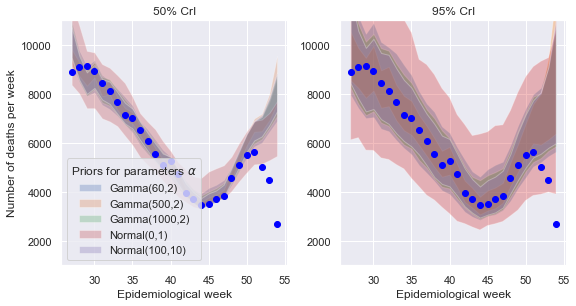

In [12]:
plot_all(crI=50, mean = False, models = [0,1,2,3,4])
plt.show()

### Figure S9

INFO:numba.core.transforms:finding looplift candidates


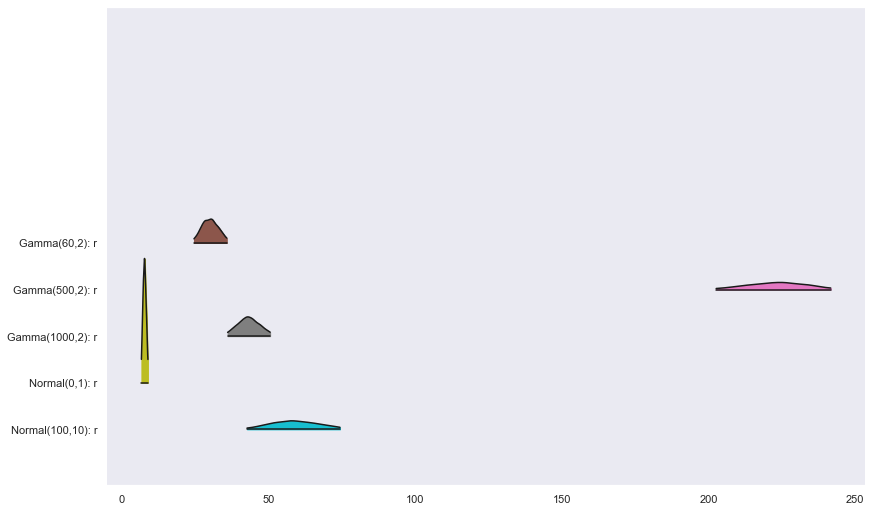

In [13]:
models_names = ['Gamma(60,2)', 'Gamma(500,2)', 'Gamma(1000,2)', 
                'Normal(0,1)', 'Normal(100,10)']
axes = arviz.plot_forest(
    all_fits, 
    model_names= models_names, 
    var_names=["r"],
    combined=True,
    colors=sns.color_palette('tab10'),
    kind = 'ridgeplot',
    ridgeplot_overlap = 5,
    figsize=(12, 7)
)

### Other plots (not published)

INFO:numba.core.transforms:finding looplift candidates


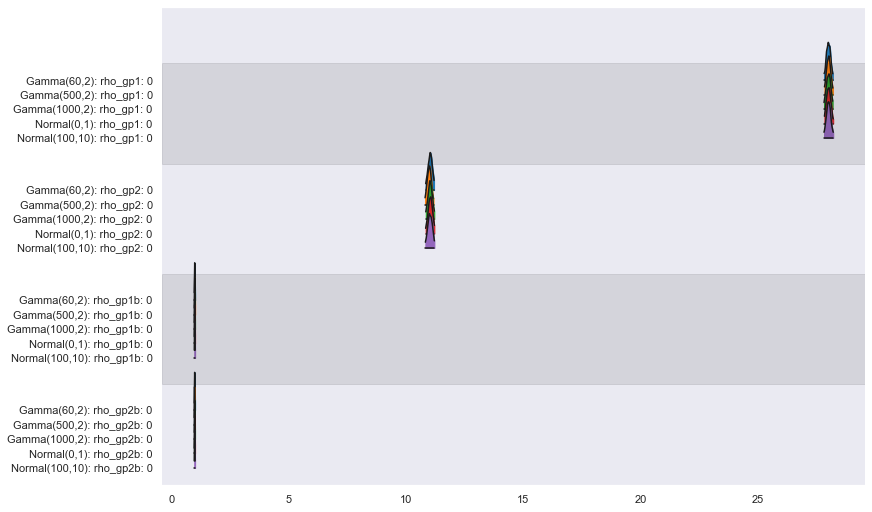

In [14]:
axes = arviz.plot_forest(
    all_fits, 
    model_names = models_names,
    var_names=["rho_gp1", "rho_gp2", "rho_gp1b", "rho_gp2b"],
    combined=True,
    kind = 'ridgeplot',
    ridgeplot_overlap = 5,
    figsize=(12, 7)
)

INFO:numba.core.transforms:finding looplift candidates


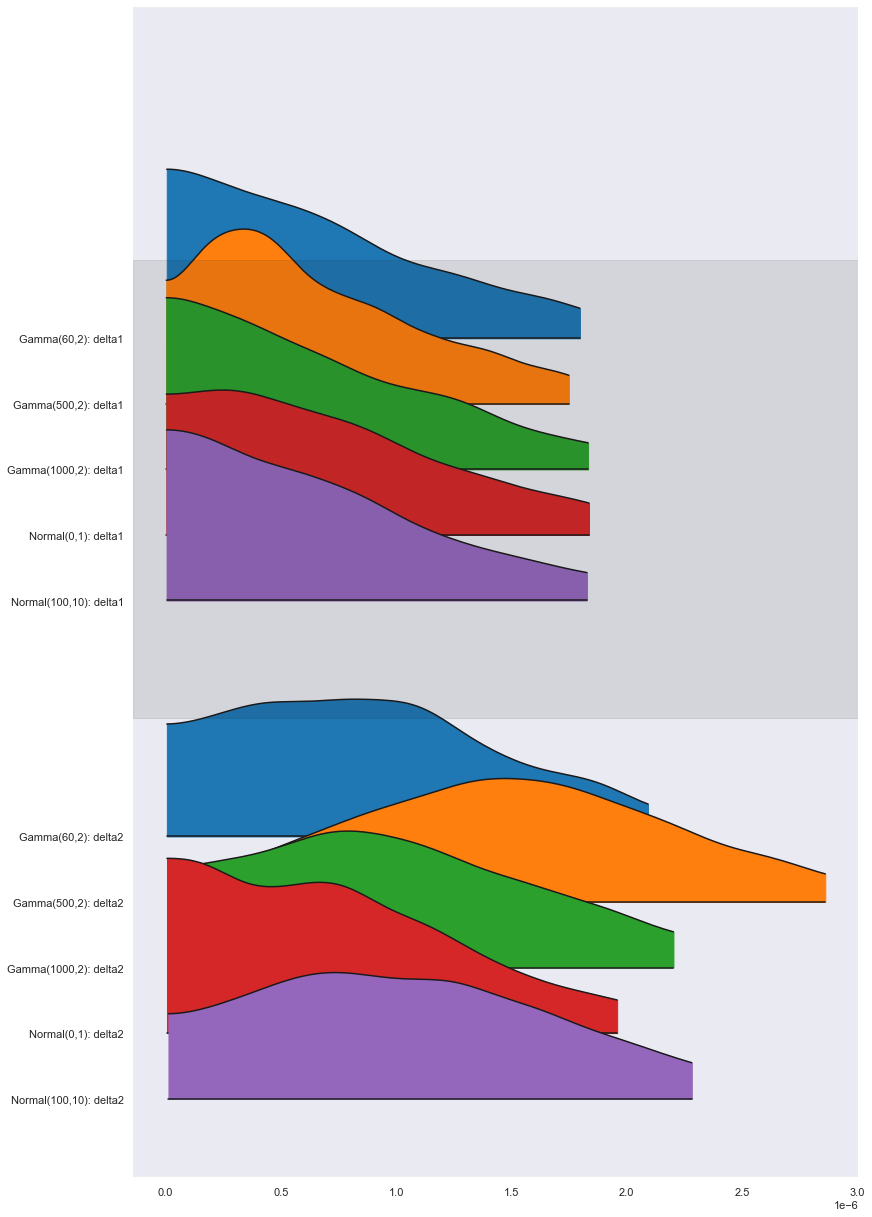

In [19]:
axes = arviz.plot_forest(
    all_fits, 
    model_names = models_names,
    var_names=["delta1", "delta2"],
    combined=True,
    kind = 'ridgeplot',
    ridgeplot_overlap = 5
)

INFO:numba.core.transforms:finding looplift candidates


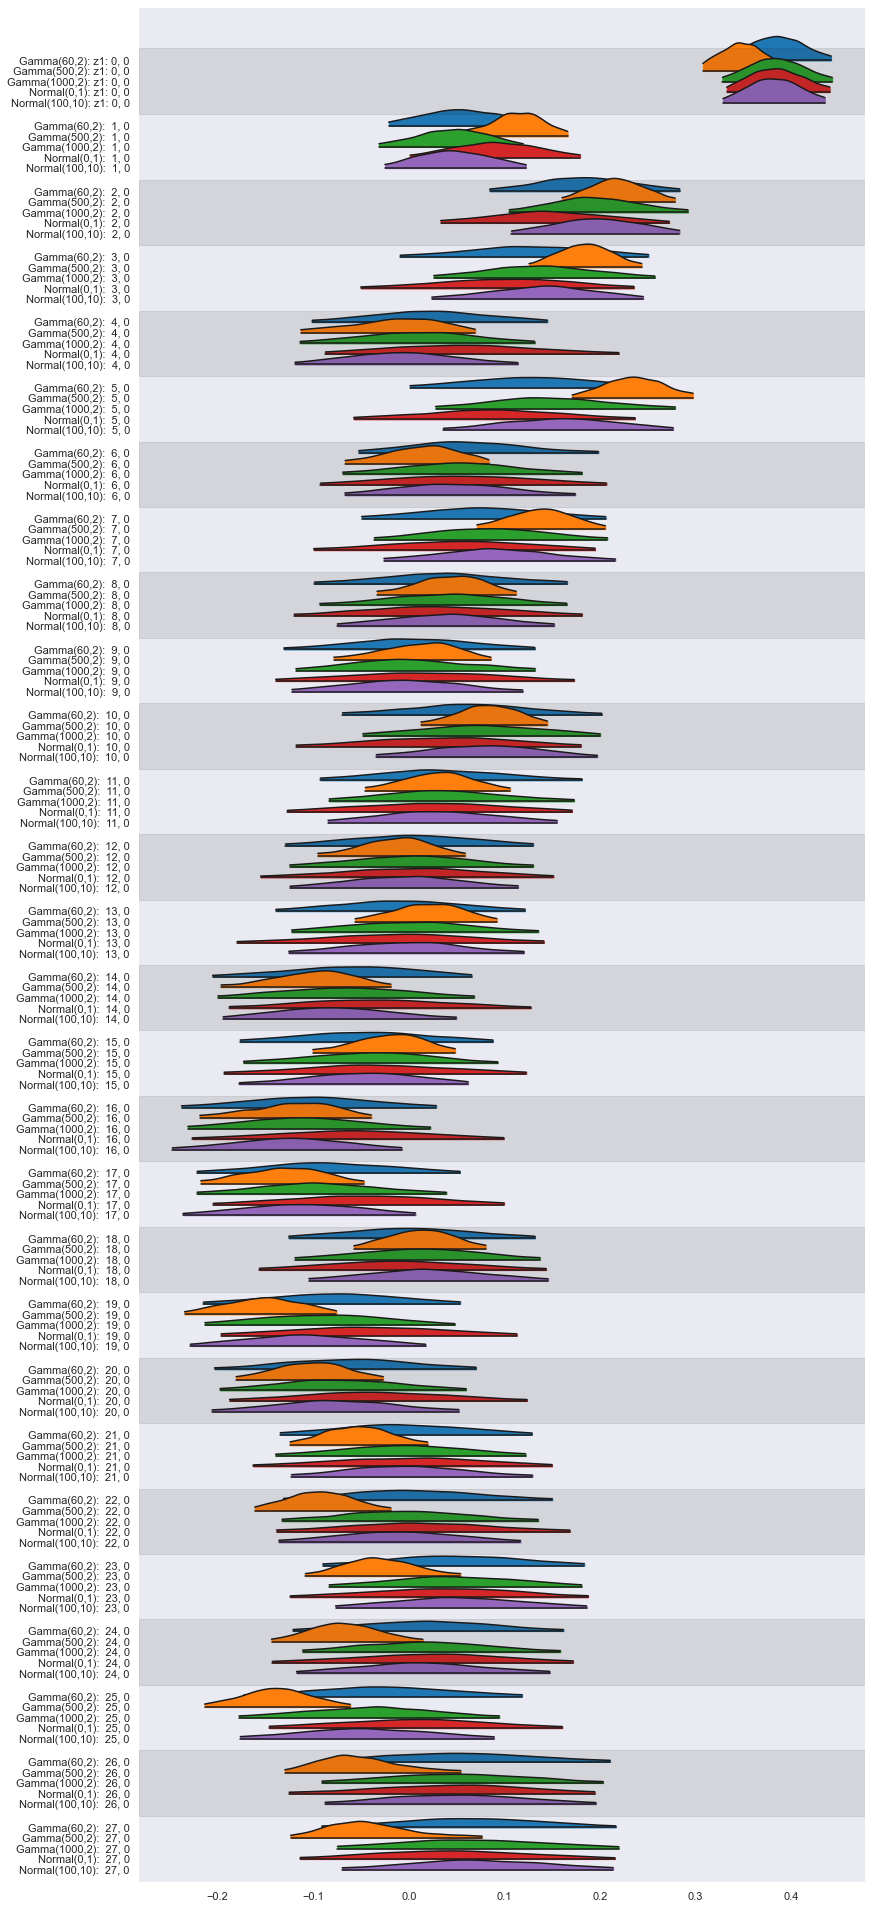

In [16]:
axes = arviz.plot_forest(
    all_fits, 
    model_names= models_names,
    var_names=["z1"],
    combined=True,
    kind = 'ridgeplot',
    ridgeplot_overlap = 5,
)

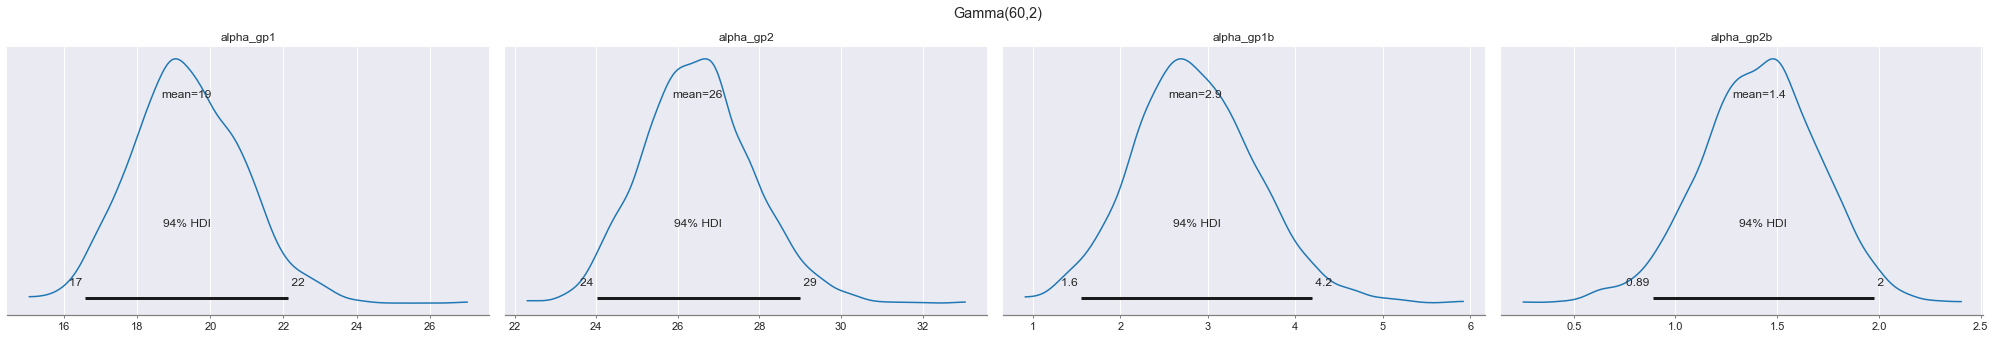

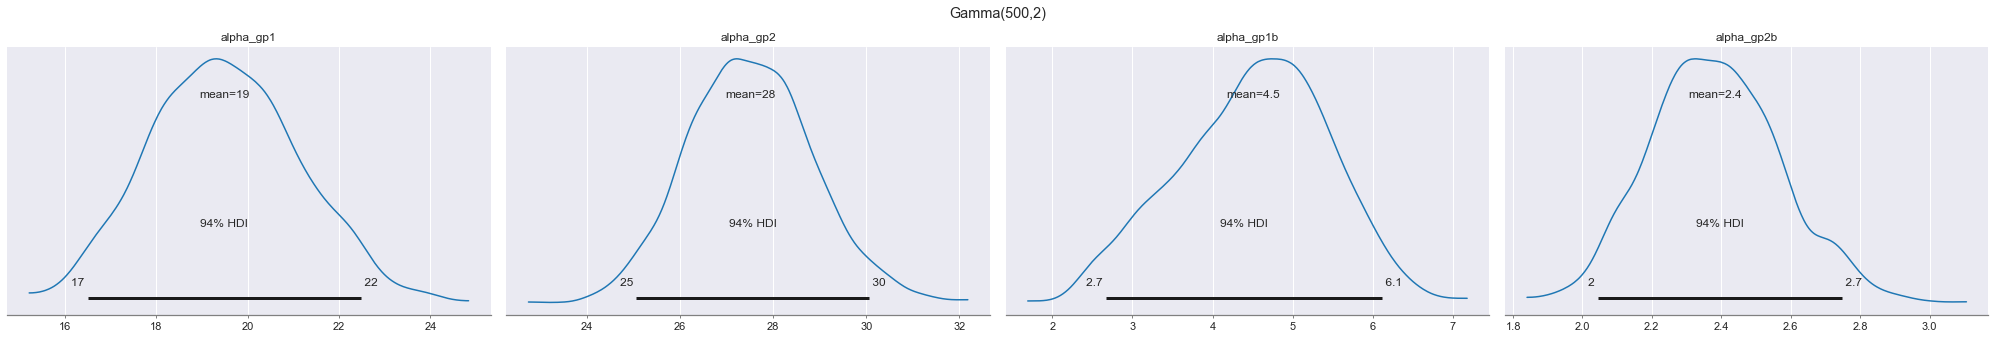

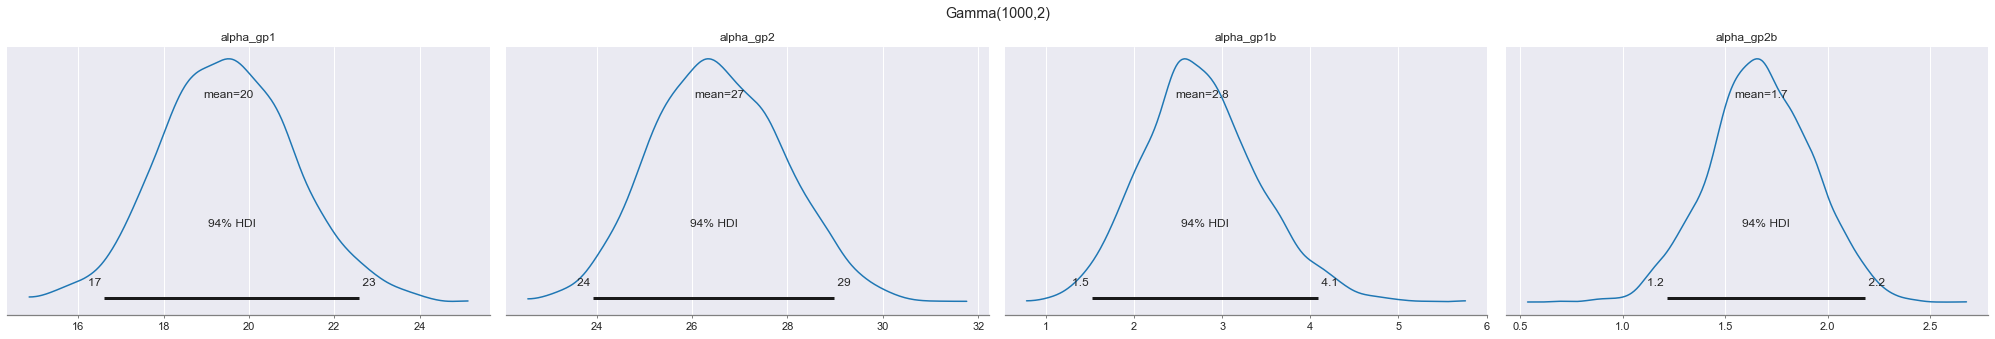

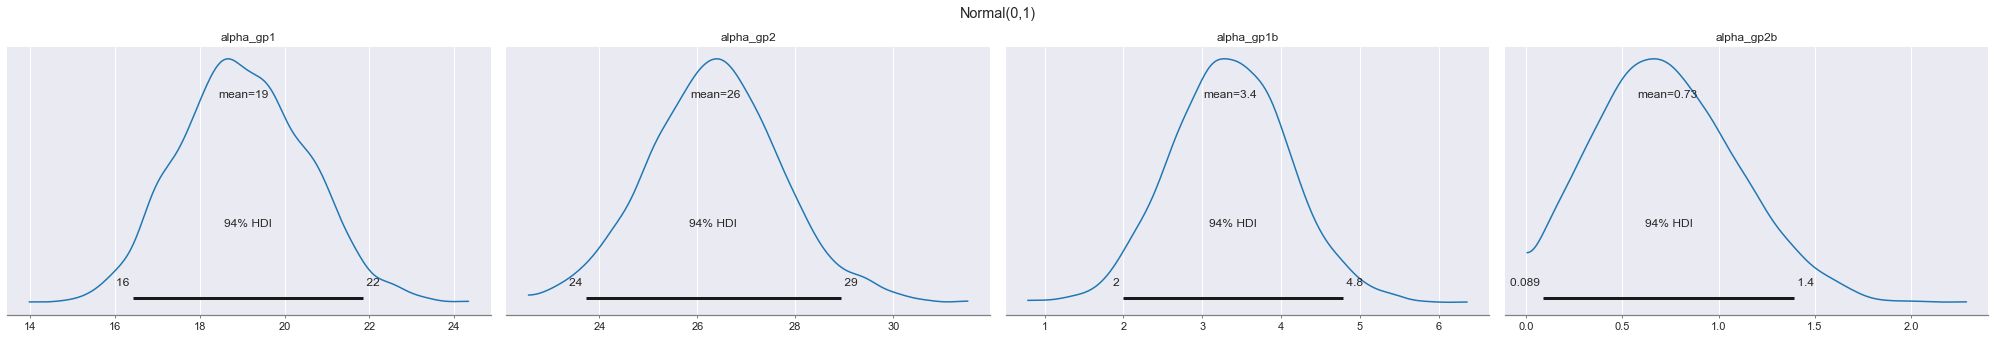

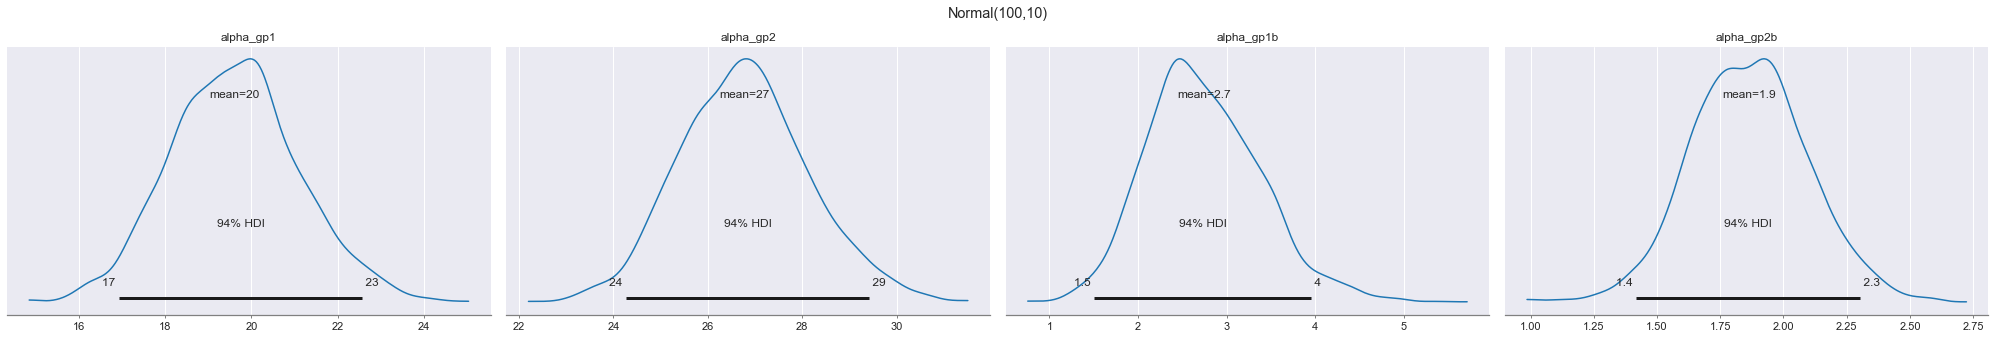

In [17]:
def plot_posteriors(fit, title):
    arviz.plot_posterior(
        fit,
        var_names=["alpha_gp1", "alpha_gp2", "alpha_gp1b", "alpha_gp2b"]
    )
    plt.suptitle(title)
    
models_names = models_names

f = []
for i in range(len(all_fits)):
    f1 = plot_posteriors(all_fits[i], models_names[i])
